In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import jax
from Network_models import HD_cell, GD_cell_hexagonal, circle_period, GD_cell
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.signal import find_peaks, peak_widths

%matplotlib inline
%load_ext autoreload
%autoreload 2

(4000, 2)


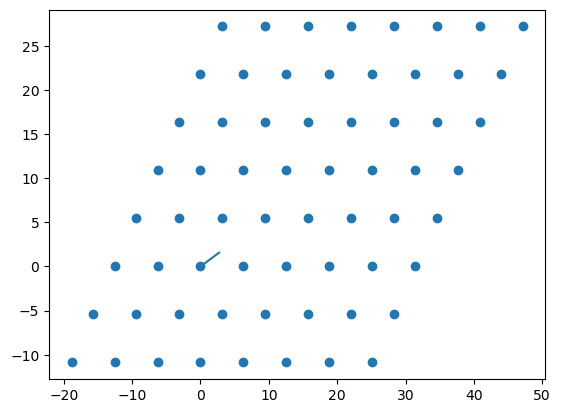

In [2]:
# simulation time step
bm.set_dt(1.)

# 环境设置
x1 = -np.pi
x2 = np.pi
x_bound = np.array([x1, x2, x2, x1, x1])
y_bound = np.array([x1, x1, x2, x2, x1])

num_hd = 100
noise_stre = 0.2
v0 = bm.pi/1000
offset_len = 1/2 * (1/v0)
Animal_speed = v0/2
A = 1.6 #1.6
mbar = 20. 
alpha_gc = 0.5
alpha_hd = 0.3
# theta_modulation_stre_hd = alpha_hd * (1/v0) * Animal_speed
# theta_modulation_stre_hd = alpha_hd * 1/v0 * Animal_speed
theta_modulation_stre_hd = alpha_hd * (1/v0) * Animal_speed
theta_modulation_stre_gc = alpha_gc * 1/v0 * Animal_speed
theta_modulation_stre_gc = bm.where(theta_modulation_stre_gc>0, theta_modulation_stre_gc, 0)


numT = 4000

Grid_net = GD_cell_hexagonal(
    ratio = 1.,
    A = A, # 3
    a = 0.8,
    k = 1.0,
    tau = 10.,
    tau_v = 100.,
    mbar = mbar, # 20.
    offset_len = offset_len, 
    noise_stre = noise_stre,
    num_hd = num_hd,
)

HD_net = HD_cell(num=num_hd, 
                 noise_stre=noise_stre/100, 
                 tau=10., tau_v=100., 
                 k=1., mbar=20, a=0.4, A=3., J0=4., 
                 z_min=-bm.pi, z_max=bm.pi)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Moving_speed):  # 20 x size
    T_theta = 100
    #calculate TheataModulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta # theta phase（0,1）
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = 1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)
    #calculate ThetaShutdown at time step i (whether to shut down the newtork activity or not)
    ThetaShutdown = 0. #bm.where(theta_phase>0.5, -1, 0)
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD)
    Internal_direction = HD_net.center #center of mass of internal direction
    HD_activity = HD_net.r 
    #update the grid cell network 
    Grid_net.step_run(i, Animal_location, HD_activity, ThetaModulator_GC, ThetaShutdown, Moving_speed)
    
    #get results
    GC_bumpcenter = Grid_net.center_pos
    center_grid_input = Grid_net.center_conjG
    GC_bumpactivity = Grid_net.r
    return GC_bumpcenter, Internal_direction, center_grid_input, GC_bumpactivity, HD_activity


# run network

time_steps = np.arange(numT)

def straight_line(x0, v, angle, T):
    x = []
    y = []
    xt = x0
    yt = x0
    for i in range(T):
        xt = xt + v * bm.cos(angle) * bm.dt
        yt = yt + v * bm.sin(angle) * bm.dt
        x.append(xt)
        y.append(yt)
    Animal_location = np.array([x,y])
    return Animal_location

hd_angle = np.pi/6
Animal_location = straight_line(0, v=Animal_speed, angle = hd_angle, T=numT)
Animal_location = Animal_location.transpose()
print(Animal_location.shape)
Head_direction = hd_angle*bm.ones(numT) #fixed head direction, mimicking the animal running in a straight line
Moving_speed = Animal_speed*bm.ones([numT,1])
plt.plot(Animal_location[:,0],Animal_location[:,1])

Candidate_pos = Grid_net.Candidate_center
plt.scatter(Candidate_pos[:,0],Candidate_pos[:,1])


  0%|          | 0/4000 [00:00<?, ?it/s]

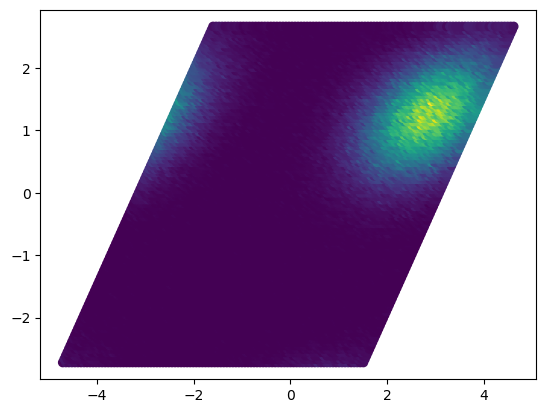

In [3]:
Grid_net.center_pos = Animal_location[0]
center_grid, center_HD, center_grid_input, r_grid, r_HD = bm.for_loop(
    run_CoupleNet, (time_steps, Animal_location, Head_direction, Moving_speed), progress_bar=True
)
pos_grid = Grid_net.pos_grid
plt.scatter(pos_grid[:,0], pos_grid[:,1], c=r_grid[-1,:])

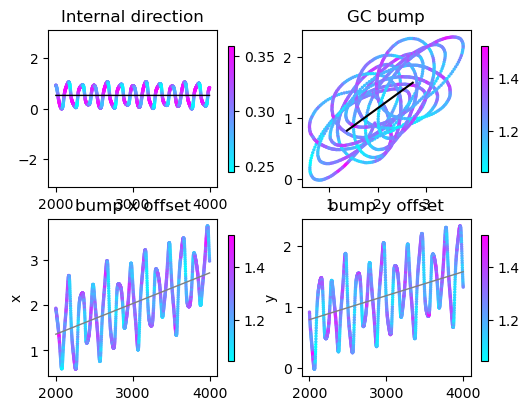

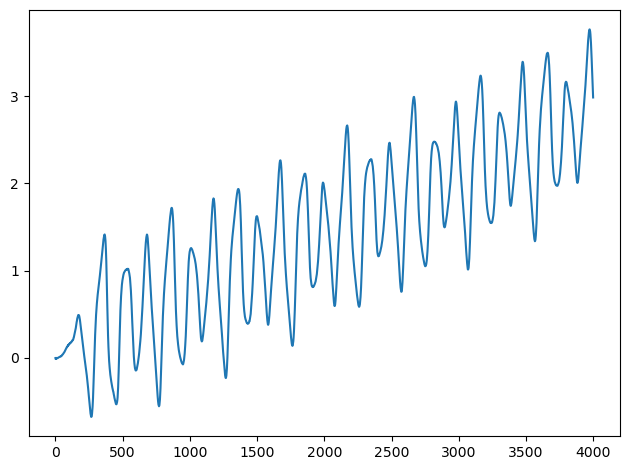

In [4]:
max_r_grid = np.max(r_grid, axis=1) 
start=int(numT/2)
max_bump_activity = np.max(r_HD, axis=1)
fig, axs = plt.subplots(2, 2, figsize=(6, 4.5))
s_size = 2
plt.figure()
plt.plot(center_grid[:,0])


ax = axs[0, 0]
ax.plot(time_steps[start:], Head_direction[start:], linewidth=1, color='black')

# cb = ax.scatter(time_steps[10:], 
#                 center_HD[10:], 
#                 c=max_bump_activity[10:], 
#                 cmap='cool', s=s_size)
cb = ax.scatter(time_steps[start:], 
                center_HD[start:], 
                c=max_bump_activity[start:], 
                cmap='cool', s=s_size)
ax.set_ylim(-bm.pi, bm.pi)
#colorbar
cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
ax.set_title('Internal direction')

ax = axs[0, 1]
sc = ax.scatter(
                center_grid[start:, 0],
                center_grid[start:, 1],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.plot(Animal_location[start:, 0], Animal_location[start:, 1], color="black")
ax.set_title('GC bump')


ax = axs[1, 0]
# ax.scatter(range(len(center_grid[start:, 0])), x[start:], s=1, color='grey')
ax.plot(time_steps[start:], Animal_location[start:,0], color='grey', linewidth=1)
ax.set_ylabel("x")
sc = ax.scatter(
                time_steps[start:],
                center_grid[start:, 0],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump x offset')


ax = axs[1, 1]
# ax.scatter(range(len(center_grid[start:, 0])), x[start:], s=1, color='grey')
ax.plot(time_steps[start:], Animal_location[start:,1], color='grey', linewidth=1)
ax.set_ylabel("y")
sc = ax.scatter(
                time_steps[start:],
                center_grid[start:, 1],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump y offset')

plt.tight_layout()
plt.show()

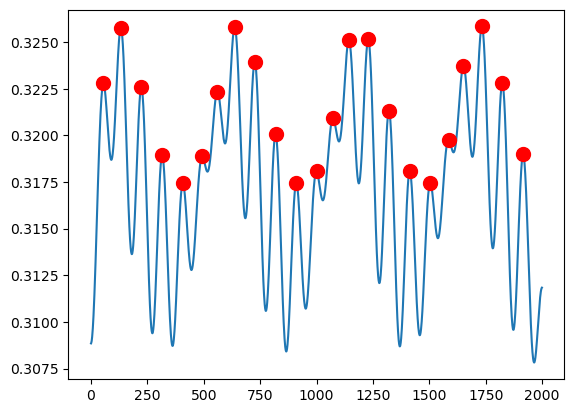

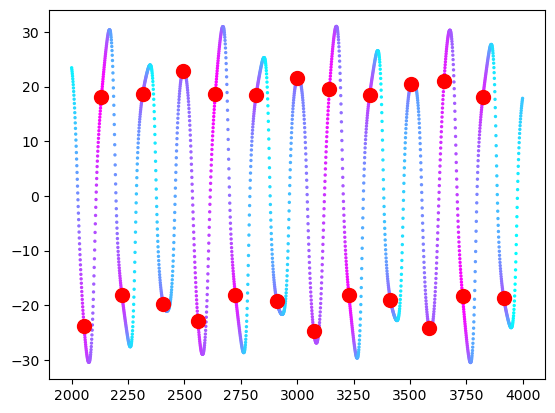

theta period of head-direction sweeps [92. 92. 88. 74. 75. 83. 91. 92. 90. 80. 71. 81. 89. 92. 91. 85. 71. 78.
 86. 91. 92. 89.]
sweep amplitude of head-direction sweeps [-23.884285  18.11167  -18.18181   18.619104 -19.87207   22.862452
 -22.908543  18.724148 -18.161196  18.489676 -19.324726  21.541986
 -24.754797  19.569527 -18.0919    18.416815 -18.969236  20.515602
 -24.203705  21.078796 -18.37898   18.050577 -18.775005]


In [5]:
from scipy.ndimage import gaussian_filter1d
start=int(numT/2)
data = circle_period(center_HD[start:].reshape(-1)-Head_direction[start:].reshape(-1))
data = data/np.pi*180
pks, _ = find_peaks(np.abs(data))
distances = np.diff(pks)
max_fr = gaussian_filter1d(max_bump_activity[start:], sigma=30)
pks_hdfr, _ = find_peaks(max_fr)
# widths = peak_widths(max_bump_activity[start:], pks_hdfr, rel_height=0.5)[0]
# pks_hdfr = pks_hdfr[widths >= 20]
plt.figure()
plt.plot(max_fr)
plt.plot(pks_hdfr, max_fr[pks_hdfr],'r.',markersize=20)

plt.figure()
# plt.plot(data)
plt.scatter(time_steps[start:], 
            data, 
            c=max_fr, 
            cmap='cool', s=s_size)
plt.plot(pks_hdfr+start, data[pks_hdfr],'r.',markersize=20)

# plt.plot(pks+start, data[pks],'r.',markersize=20)
# plt.plot(troughs_hd, data[troughs_hd],'b.',markersize=20)
plt.show()
print('theta period of head-direction sweeps', distances*bm.dt)
print('sweep amplitude of head-direction sweeps', data[pks_hdfr])
hd_direction = data[pks_hdfr]

# sweep_amplitude = (np.max(data)-np.min(data))/2

(2000,)
theta period of grid cell peaks [150. 164. 184. 140. 172. 182. 138. 177. 179. 139. 180.]
theta period of grid cell troughs [181. 140. 176. 171. 145. 182. 155. 158. 182. 151. 164.]
sweep amplitude of grid cell sweeps 2.4852917


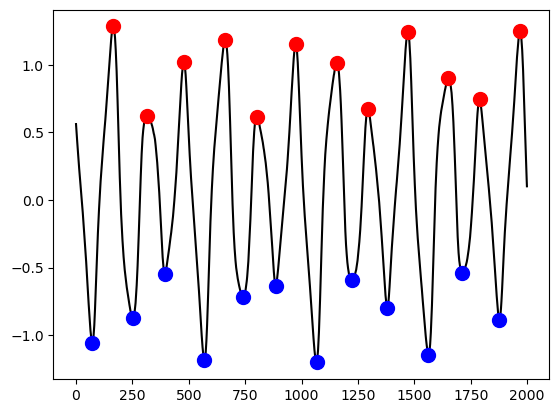

In [6]:

start=int(numT/2)
dis_x_grid = center_grid[start:, 0].reshape(-1)-Animal_location[start:, 0].reshape(-1)
dis_y_grid = center_grid[start:, 1].reshape(-1)-Animal_location[start:, 1].reshape(-1)
dis_vec = bm.array([dis_x_grid, dis_y_grid])
moving_vec = bm.array([bm.cos(hd_angle), bm.sin(hd_angle)]).reshape(1,2)
projection = bm.matmul(moving_vec, dis_vec).reshape(-1,)
print(projection.shape)

data = projection
peaks_grid, _ = find_peaks(data)
troughs_grid, _ = find_peaks(-data)
# 计算每个峰的宽度
widths_pks = peak_widths(data, peaks_grid, rel_height=0.5)[0]
widths_trs = peak_widths(-data, troughs_grid, rel_height=0.5)[0]
# 筛选出具有最小宽度的峰
peaks_grid = peaks_grid[widths_pks >= 20]
troughs_grid = troughs_grid[widths_trs >= 20]
plt.figure()
plt.plot(projection,'k')
plt.plot(peaks_grid,projection[peaks_grid],'r.',markersize=20)
plt.plot(troughs_grid,projection[troughs_grid],'b.',markersize=20)
distances_peaks = np.diff(peaks_grid)
distances_troughs = np.diff(troughs_grid)
print('theta period of grid cell peaks', distances_peaks*bm.dt)
print('theta period of grid cell troughs', distances_troughs*bm.dt)
print('sweep amplitude of grid cell sweeps', np.max(data)-np.min(data))

hd sweep angle: [-23.884285  18.11167  -18.18181   18.619104 -19.87207   22.862452
 -22.908543  18.724148 -18.161196  18.489676 -19.324726  21.541986
 -24.754797  19.569527 -18.0919    18.416815 -18.969236  20.515602
 -24.203705  21.078796 -18.37898   18.050577 -18.775005]
gc sweep angle: [ -4.11330918  15.31191494 -16.276624     3.67193371  10.30218003
 -17.24429053  10.36975219  -0.42258248 -14.37259031  13.73650447
  -7.26528634 -11.23649967]


(-3.141592653589793, 3.141592653589793)

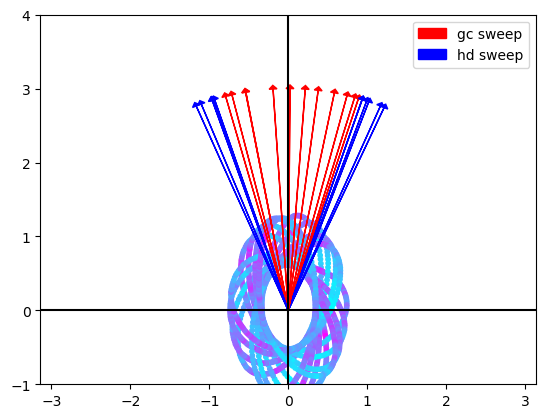

In [7]:
W_rotate = np.array([[np.cos(np.pi/2-hd_angle), -np.sin(np.pi/2-hd_angle)], [np.sin(np.pi/2-hd_angle), np.cos(np.pi/2-hd_angle)]])
Dis = np.array([dis_x_grid, dis_y_grid])
Dis_rotate = np.matmul(W_rotate, Dis)
max_r_grid = np.max(r_grid, axis=1) 
fig, ax = plt.subplots()
sc = ax.scatter(
                Dis_rotate[0,:],
                Dis_rotate[1,:],
                c=max_r_grid[start:],
                cmap="cool",
                s=10,
)
Start = Dis_rotate[:, troughs_grid]
End = Dis_rotate[:, peaks_grid]

num_cycle_gc_troughs = troughs_grid.shape[0]
num_cycle_gc_peaks = peaks_grid.shape[0]
num_cycle_hd = hd_direction.shape[0]
num_cycle = np.min(np.array([num_cycle_gc_troughs, num_cycle_gc_peaks, num_cycle_hd]))
# num_cycle = troughs_grid.shape[0]
sweep_direction = np.zeros(num_cycle)
print('hd sweep angle:', hd_direction)
# hd_direction = np.zeros(num_cycle)
for i in range(num_cycle):
    # ax.arrow(Start[0,i], Start[1,i], End[0,i], End[1,i], head_width=0.1, head_length=0.05, fc='red', ec='red')

    sweep_direction[i] = np.arctan((End[0,i]-Start[0,i])/(End[1,i]-Start[1,i]))
    sweep_vector = 3 * bm.array([bm.cos(sweep_direction[i]+np.pi/2),bm.sin(sweep_direction[i]+np.pi/2)])
    ax.arrow(0, 0, sweep_vector[0], sweep_vector[1], head_width=0.1, head_length=0.05, fc='red', ec='red')

    hd_sweep_angle = hd_direction[i]/180*np.pi
    hd_vector = 3 * bm.array([bm.cos(hd_sweep_angle+np.pi/2),bm.sin(hd_sweep_angle+np.pi/2)])
    # hd_vector = bm.matmul(W_rotate, hd_vector)
    ax.arrow(0, 0, hd_vector[0], hd_vector[1], head_width=0.1, head_length=0.05, fc='blue', ec='blue')
plt.legend(['gc sweep', 'hd sweep'])

gc_angle = sweep_direction/np.pi*180
print('gc sweep angle:', gc_angle)
# 添加 x=0 处的直线
plt.axvline(x=0, color='k')
# 添加 y=0 处的直线
plt.axhline(y=0, color='k')
ax.set_ylim(-1, 4)
ax.set_xlim(-np.pi, np.pi)

0.6088421568588914


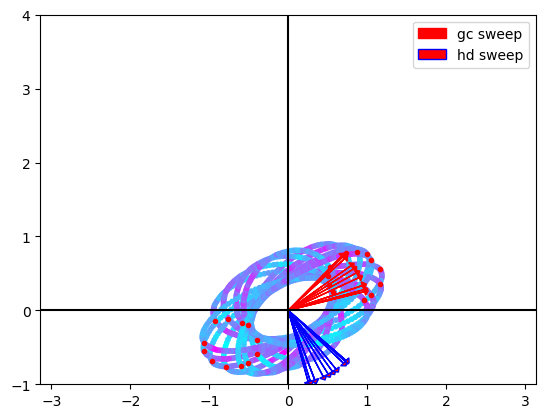

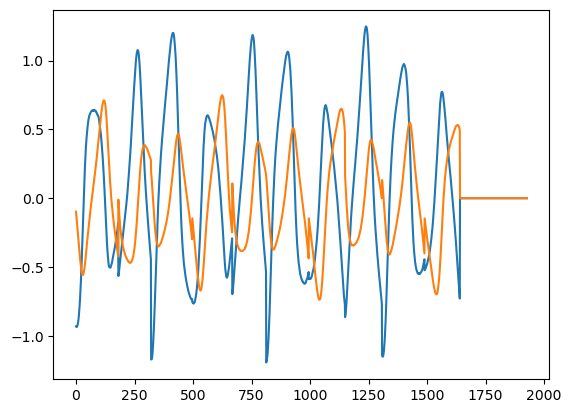

In [9]:
W_rotate = np.array([[np.cos(np.pi/2-hd_angle), -np.sin(np.pi/2-hd_angle)], [np.sin(np.pi/2-hd_angle), np.cos(np.pi/2-hd_angle)]])
Dis = np.array([dis_x_grid, dis_y_grid])
Dis_rotate = np.matmul(W_rotate, Dis)
max_r_grid = np.max(r_grid, axis=1) 
fig, ax = plt.subplots()
sc = ax.scatter(
                Dis[0,:],
                Dis[1,:],
                c=max_r_grid[start:],
                cmap="cool",
                s=10,
)
Start = Dis[:, troughs_grid]
End = Dis[:, peaks_grid]

num_cycle_gc_troughs = troughs_grid.shape[0]
num_cycle_gc_peaks = peaks_grid.shape[0]
# print(troughs_grid)
# print(peaks_grid)
num_cycle_hd = hd_direction.shape[0]
num_cycle = np.min(np.array([num_cycle_gc_troughs, num_cycle_gc_peaks, num_cycle_hd]))

# num_cycle = troughs_grid.shape[0]
sweep_direction = np.zeros(num_cycle)
# short_axis = np.zeros(num_cycle)
long_axis_projection = np.zeros(int(numT/2)-troughs_grid[0])
short_axis_projection = np.zeros(int(numT/2)-troughs_grid[0])

for i in range(num_cycle-1):
    sweep_direction[i] = np.arctan((End[1,i]-Start[1,i])/(End[0,i]-Start[0,i]))
    sweep_vector = np.array([np.cos(sweep_direction[i]),np.sin(sweep_direction[i])])
    sweep_vector_perp = np.array([np.cos(sweep_direction[i]-np.pi/2),np.sin(sweep_direction[i]-np.pi/2)])

    ax.arrow(0, 0, sweep_vector[0], sweep_vector[1], head_width=0.1, head_length=0.05, fc='red', ec='red')
    ax.arrow(0, 0, sweep_vector_perp[0], sweep_vector_perp[1], head_width=0.1, head_length=0.05, fc='red', ec='blue')
    if i >= 1:
        phase_window = troughs_grid[i] - troughs_grid[i-1]
        for j in range(phase_window):
            long_axis_projection[troughs_grid[i-1]+j-troughs_grid[0]] = np.sum(Dis[:,troughs_grid[i]+j].reshape(-1,)*sweep_vector.reshape(-1,))
            short_axis_projection[troughs_grid[i-1]+j-troughs_grid[0]] = np.sum(Dis[:,troughs_grid[i]+j].reshape(-1,)*sweep_vector_perp.reshape(-1,))

plt.legend(['gc sweep', 'hd sweep'])
plt.plot(Start[0,:], Start[1,:],'r.')
plt.plot(End[0,:], End[1,:],'r.')

# 添加 x=0 处的直线
plt.axvline(x=0, color='k')
# 添加 y=0 处的直线
plt.axhline(y=0, color='k')
ax.set_ylim(-1, 4)
ax.set_xlim(-np.pi, np.pi)

plt.figure()
plt.plot(long_axis_projection)
plt.plot(short_axis_projection)

long_axis = np.max(long_axis_projection)-np.min(long_axis_projection)
short_axis = np.max(short_axis_projection)-np.min(short_axis_projection)
cyclic_score = short_axis/long_axis
print(cyclic_score)
